In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


C:\Temp\ipykernel_11312\1683832715.py:83: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


Epoch 1/50



448/448 [==============================] - 299s 664ms/step - loss: 1.8026 - accuracy: 0.2556 - val_loss: 1.7049 - val_accuracy: 0.3412
Epoch 2/50
448/448 [==============================] - 103s 230ms/step - loss: 1.6254 - accuracy: 0.3653 - val_loss: 1.5265 - val_accuracy: 0.4178
Epoch 3/50
448/448 [==============================] - 108s 240ms/step - loss: 1.5195 - accuracy: 0.4151 - val_loss: 1.4587 - val_accuracy: 0.4406
Epoch 4/50
448/448 [==============================] - 109s 243ms/step - loss: 1.4458 - accuracy: 0.4467 - val_loss: 1.3928 - val_accuracy: 0.4682
Epoch 5/50
448/448 [==============================] - 116s 260ms/step - loss: 1.3905 - accuracy: 0.4692 - val_loss: 1.3410 - val_accuracy: 0.4918
Epoch 6/50
448/448 [==============================] - 129s 287ms/step - loss: 1.3392 - accuracy: 0.4879 - val_loss: 1.3016 - val_accuracy: 0.5018
Epoch 7/50
448/448 [==============================] - 115s 257ms/step - loss: 1.2946 - accuracy: 0.5074 - val_loss: 1.2620 - val_accura

TypeError: 5.0 must be a sequence

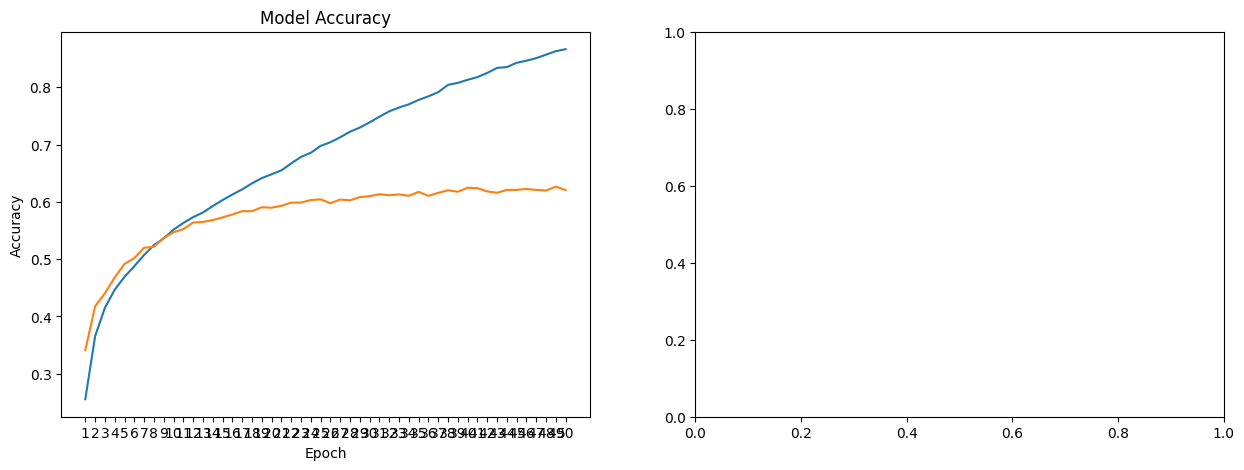

In [13]:
# ap = argparse.ArgumentParser()
# ap.add_argument("--mode",help="train/display")
# mode = ap.parse_args().mode
mode = "train"
# plots accuracy and loss curves
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

# Define data generators
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
def lr_schedule(epoch):
    return 0.0001 * 0.1**(epoch / 10)
from tensorflow.keras.callbacks import LearningRateScheduler
optimizer = Adam(learning_rate=0.0001)
optimizer.learning_rate_cheduler = LearningRateScheduler(lr_schedule)

# If you want to train the same model or try other models, go for this
if mode == "train":
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=num_epoch,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)
    # plot_model_history(model_info)
    model.save_weights('model.h5')

# emotions will be displayed on your face from the webcam feed
elif mode == "display":
    model.load_weights('model.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

    # start the webcam feed
    cap = cv2.VideoCapture(0)
    while True:
        # Find haar cascade to draw bounding box around face
        ret, frame = cap.read()
        if not ret:
            break
        facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
            prediction = model.predict(cropped_img)
            maxindex = int(np.argmax(prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [7]:
%tb


SystemExit: 2